In [1]:
# !pip install PIL
# !pip install wheel==0.38.4
# !pip install setuptools==65
# !pip install gym==0.21
# !pip install torchrl
# # pip install stable-baselines3[extra]
# !pip install torchvision
# !pip install gym==0.21
# !pip install --upgrade ipykernel
# !pip install matplotlib
# !pip install gym[atari,accept-rom-license]==0.21.0
# !pip install joblib
# !pip install tqdm
# !pip install image

In [2]:
# hide imports
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import gym
import torchvision
import numpy as np
import torchrl
import torch
import logging
import tqdm
from torchrl.envs import *
from torchrl.envs.libs.gym import *
from joblib import Parallel, delayed
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')

random_seed = 21

torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("deivce is", device)

deivce is cpu


In [3]:
gym.version.VERSION

'0.21.0'

In [4]:
from Environment.Environment import *

env_name = "CartPole-v1"

env = get_environment(env_name, width=200, height=200)
n_actions = env.action_space.n

state = env.reset()

print(state)

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        pixels: Tensor(shape=torch.Size([400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
        pixels_trsf: Tensor(shape=torch.Size([4, 200, 200]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


In [5]:
state = env.reset()
cnt = 0

for t in range(0):

    print("frame", cnt)
    cnt += 1
    plt.imshow(state['pixels_trsf'][0].cpu().permute(0, 1), cmap="gray")
    plt.show()
    print("frame", cnt)
    cnt += 1
    plt.imshow(state['pixels_trsf'][1].cpu().permute(0, 1), cmap="gray")
    plt.show()
    print("frame", cnt)
    cnt += 1
    plt.imshow(state['pixels_trsf'][2].cpu().permute(0, 1), cmap="gray")
    plt.show()
    print("frame", cnt)
    cnt += 1
    plt.imshow(state['pixels_trsf'][3].cpu().permute(0, 1), cmap="gray")
    plt.show()

    print(state['pixels_trsf'][0])

    for i in range(3):
        a = np.asarray(state['pixels_trsf'][i].cpu().permute(0, 1))
        b = np.asarray(state['pixels_trsf'][i + 1].cpu().permute(0, 1))
        if a.all() != b.all():
            print("frames", i, "and", i + 1, "not equal")
        else:
            print("frames", i, "and", i + 1, "not equal")

    state['action'] = torch.zeros(n_actions)
    state['action'][0] = 0

    state = env.step(state)['next']

    print("reward is", state['reward'])

In [6]:
from Agent import AgentDDQN


agent = AgentDDQN.Agent(num_channels=FRAME_SKIP, width=W, height=H, n_actions=n_actions)

In [7]:
from Learning.Learning import Learning

learn = Learning(env_name)

In [8]:
loading = False

In [9]:
print(agent.get_epsilon())

1.0


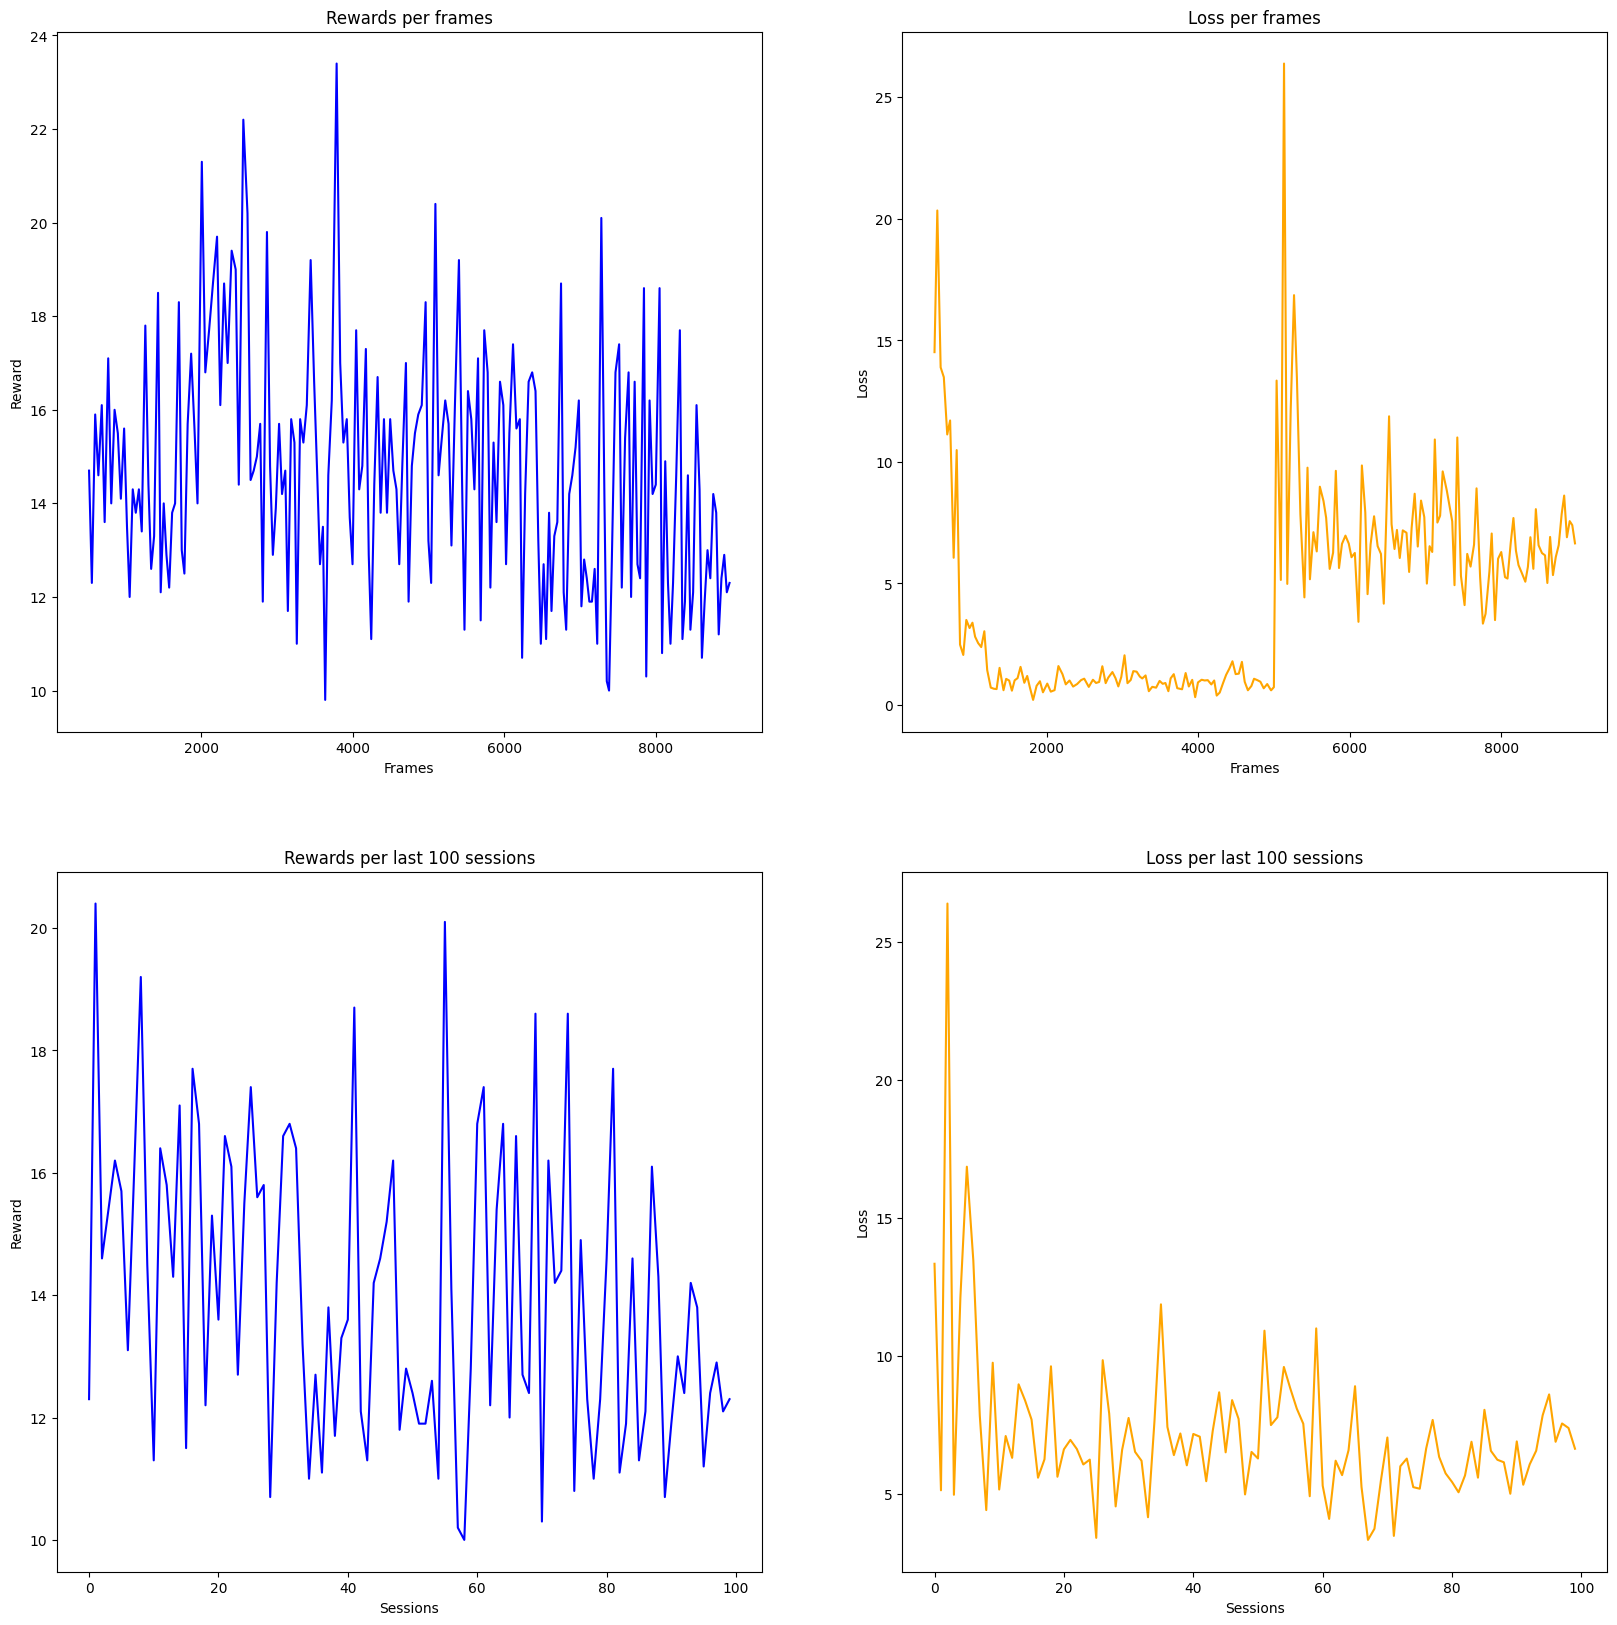

for frame =  8974 , epsilon =  0.5420926760000001


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]

loss is 5.958613395690918
loss is 5.958613395690918
loss is 5.958613395690918
tensor(5.9586, grad_fn=<MeanBackward0>)
loss is 5.958613395690918
tensor(5.9586, grad_fn=<MeanBackward0>)
loss is 5.958613395690918
tensor(5.9586, grad_fn=<MeanBackward0>)


In [10]:
if loading:
    try:
        agent.load()
    except:
        pass

agent.save()

print("preparing (add random states to replay buffer)")
if not loading:
    for i in tqdm.tqdm(range(100)):
        learn.play_session(agent, epsilon=1)
else:
    for i in tqdm.tqdm(range(20)):
        learn.play_session(agent)

epoch = 0
while True:
    rewards = np.asarray([])
    for _ in tqdm.tqdm(range(10)):
        reward_for_session = learn.play_session(agent, t_max=(int)(agent.t_max))
        reward_for_session = np.asarray(torch.as_tensor(reward_for_session).cpu())
        rewards = np.concatenate([rewards, reward_for_session])
    
    # loss = agent.train(batch_size)
    
    Loss = agent.train(32)
    agent.loss_history.append(Loss)
    agent.reward_history.append(np.mean(rewards))
    agent.frames.append(agent.cnt_frames)
    clear_output(True)
    
    agent.plot_results()
    print("for frame = ", agent.cnt_frames, ", epsilon = ", agent.get_epsilon())


    agent.t_max *= 1.01
    epoch += 1
    agent.t_max = min(agent.t_max, (int)(4e4))

    if epoch % 10 == 1:
        agent.save()
        print('saved successfully')     